# ME 454 Homework 7
## By: Christopher Tsai

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

Problem 1:

In [26]:
N = 1000
T = 2*np.pi
dt = T/(N-1)
t_span = np.linspace(0, T, N + 1)

def initial_traj_ode(t, x_z):
    x_z = x_z.reshape((6, 1))
    x = x_z[0, 0]
    y = x_z[1, 0]
    theta = x_z[2, 0]
    u1 = 1
    u2 = -1/2
    xdot = np.cos(theta)*u1
    ydot = np.sin(theta)*u1
    thetadot = u2
    z = x_z[3:6]
    A = np.array([[0, 0, -np.sin(theta)*u1], [0, 0, np.cos(theta)*u1], [0, 0, 0]])
    B = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
    v = np.vstack(([-0.5*np.sin(t) - 0.1], [0.5*np.cos(t)]))
    zdot = A@z + B@v
    return xdot, ydot, thetadot, zdot[0, 0], zdot[1, 0], zdot[2, 0]

initial_traj = integrate.solve_ivp(initial_traj_ode, (0, T), (0, 0, np.pi/2, 0, 0, 0), t_eval=t_span)

x = initial_traj.y[0:3, :]
u = np.array([[1 for t in t_span], [-1/2 for t in t_span]])
xi = np.vstack((x, u))

z = initial_traj.y[3:6, :]
v = np.vstack(([-0.5*np.sin(t) - 0.1 for t in t_span], [0.5*np.cos(t) for t in t_span]))
zeta = np.vstack((z, v))

xd = np.vstack(([2/np.pi*t for t in t_span], [0 for t in t_span], [np.pi/2 for t in t_span]))

Q = np.array([[1000, 0, 0], [0, 1000, 0], [0, 0, 1]])
R = np.array([[100, 0], [0, 1]])
P1 = np.array([[1000, 0, 0], [0, 1000, 0], [0, 0, 100]])   

def DJ_zeta_fun(xi, zeta):
    x = xi[0:3, :]
    u = xi[3:5, :]
    z = zeta[0:3, :]
    v = zeta[3:5, :]
    DJ_zeta = 0
    for i in range(N):
        DJ_zeta += (np.dot((2*Q@(x[:, i] - xd[:, i]).reshape(3,1)).flatten(), z[:, i].flatten()) + np.dot((2*R@u[:, i].reshape(2,1)).flatten(), v[:, i].flatten()))*dt
    DJ_zeta /= 2
    return DJ_zeta

print("DJ_zeta =", DJ_zeta_fun(xi, zeta))

DJ_zeta = -4252.668686914291


Problem 2:

Number of iterations = 4


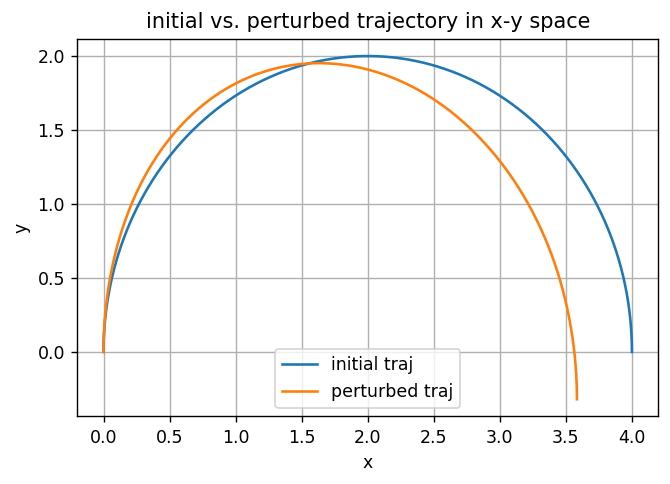

In [27]:
def J_fun(xi):
    x = xi[0:3, :]
    u = xi[3:5, :]
    J = 0
    for i in range(N):
        J += ((x[:, i] - xd[:, i]).T@Q@(x[:, i] - xd[:, i]) + u[:, i].T@R@u[:, i])*dt
    J /= 2
    J += 1/2*((x[:, -1] - xd[:, -1]).T@P1@(x[:, -1] - xd[:, -1]))
    return J

def armijo(J, DJ_zeta, xi, zeta):
    alpha = 0.4
    beta = 0.7
    n = 0
    gamma = beta**n
    
    while J_fun(xi + gamma*zeta) > J_fun(xi) + alpha*gamma*DJ_zeta_fun(xi, zeta):
        n += 1
        gamma = beta**n
        
    xi_new = xi + gamma*zeta
    return xi_new, n
    
print("Number of iterations =", armijo(J_fun(xi), DJ_zeta_fun(xi, zeta), xi, zeta)[1])

x_new = armijo(J_fun(xi), DJ_zeta_fun(xi, zeta), xi, zeta)[0][0:3, :]

plt.figure(dpi=125, facecolor='w')
plt.plot(x[0], x[1], label='initial traj')
plt.plot(x_new[0], x_new[1], label='perturbed traj')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title("initial vs. perturbed trajectory in x-y space")
plt.show()

Problem 3:

In [28]:
epsilon = 0.5

def P_r_ode(t, P_r):
    P = P_r[0:9].reshape((3, 3))
    r = P_r[9:12].reshape((3, 1))
    i = int(round(N*t/T))
    A = np.array([[0, 0, -np.sin(x[2, i])*u[0, i]], [0, 0, np.cos(x[2, i])*u[0, i]], [0, 0, 0]])
    B = np.array([[np.cos(x[2, i]), 0], [np.sin(x[2, i]), 0], [0, 1]])
    a = 2*Q@(x[:, i] - xd[:, i]).reshape(3,1)
    b = 2*R@u[:, i].reshape(2,1)
    Pdot = -(P@A + A.T@P - P@B@np.linalg.inv(R)@B.T@P + Q)
    rdot = -((A - B@np.linalg.inv(R)@B.T@P).T@r + a - P@B@np.linalg.inv(R)@b)
    return np.concatenate((Pdot.flatten(), rdot.flatten()))

def z_ode(t, z):
    z = z.reshape((3, 1))
    i = int(round(N*t/T))
    P = np.reshape(P_r[0:9, i], (3, 3))
    r = np.reshape(P_r[9:12, i], (3 ,1))
    A = np.array([[0, 0, -np.sin(x[2, i])*u[0, i]], [0, 0, np.cos(x[2, i])*u[0, i]], [0, 0, 0]])
    B = np.array([[np.cos(x[2, i]), 0], [np.sin(x[2, i]), 0], [0, 1]])   
    b = 2*R@u[:, i].reshape(2,1)
    v = -np.linalg.inv(R)@B.T@P@z - np.linalg.inv(R)@B.T@r - np.linalg.inv(R)@b
    zdot = A@z + B@v
    return zdot.flatten()

x = initial_traj.y[0:3, :]
u = np.array([[1 for t in t_span], [-1/2 for t in t_span]])
xi = np.vstack((x, u))

while np.linalg.norm(zeta) > epsilon:
    r1 = P1@np.array([x[:, -1] - xd[:, -1]]).T
    P_r_sol = integrate.solve_ivp(P_r_ode, (T, 0), np.concatenate((P1.flatten(), r1.flatten())), t_eval=np.flip(t_span))
    P_r = np.flip(P_r_sol.y, 1)
    z_sol = integrate.solve_ivp(z_ode, (0, T), (0, 0, 0), t_eval=t_span)
    z = z_sol.y
    v = np.zeros((2, N + 1))
    
    for i in range(N + 1):
        P = np.reshape(P_r[0:9, i], (3, 3))
        r = np.reshape(P_r[9:12, i], (3 ,1))
        A = np.array([[0, 0, -np.sin(x[2, i])*u[0, i]], [0, 0, np.cos(x[2, i])*u[0, i]], [0, 0, 0]])
        B = np.array([[np.cos(x[2, i]), 0], [np.sin(x[2, i]), 0], [0, 1]])   
        b = 2*R@u[:, i].reshape(2,1)
        v[:, i] = (-np.linalg.inv(R)@B.T@P@np.array([z[:, i]]).T - np.linalg.inv(R)@B.T@r - np.linalg.inv(R)@b).flatten()

    zeta = np.vstack((z, v))
    xi = armijo(J_fun(xi), DJ_zeta_fun(xi, zeta), xi, zeta)[0]
    x = xi[0:3, :]
    u = xi[3:5, :]
    print("norm of zeta =", np.linalg.norm(zeta))

norm of zeta = 123.91778178156052
norm of zeta = 47.669939975586466
norm of zeta = 41.71148309178737
norm of zeta = 19.31304251572727
norm of zeta = 14.391679363153598
norm of zeta = 7.3379427658357805
norm of zeta = 3.688238889286694
norm of zeta = 4.951102247700825
norm of zeta = 3.25173102902173
norm of zeta = 2.352190172905887
norm of zeta = 1.7987758710970594
norm of zeta = 1.430811083967339
norm of zeta = 1.1697258074902441
norm of zeta = 0.9750250437634193
norm of zeta = 0.27716284208139563


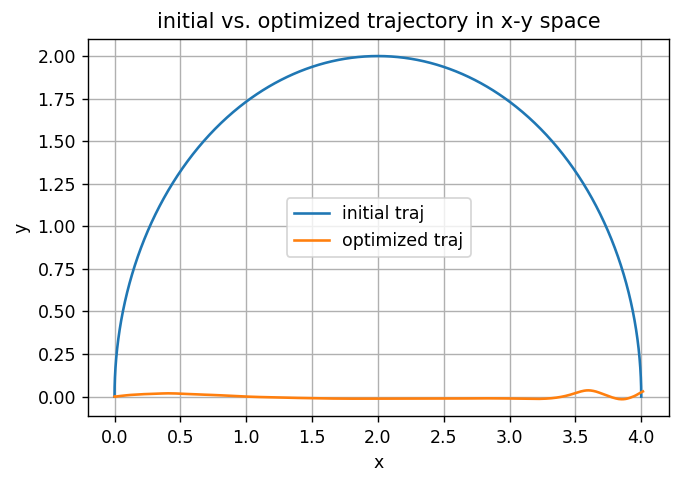

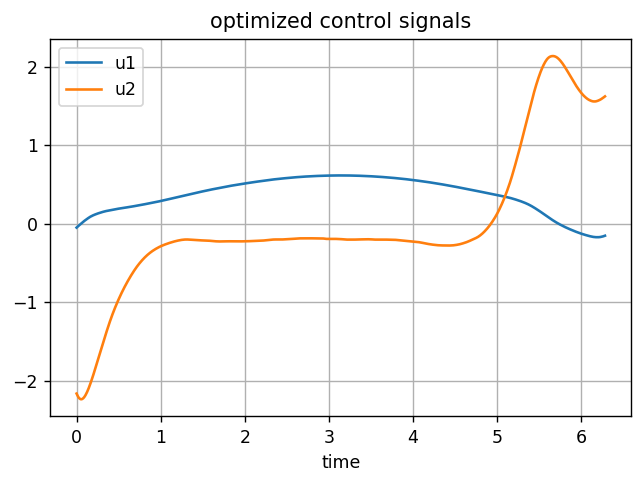

Q =
 [[1000    0    0]
 [   0 1000    0]
 [   0    0    1]]
R =
 [[100   0]
 [  0   1]]
P1 =
 [[1000    0    0]
 [   0 1000    0]
 [   0    0  100]]


In [31]:
plt.figure(dpi=125, facecolor='w')
plt.plot(initial_traj.y[0:3, :][0], initial_traj.y[0:3, :][1], label='initial traj')
plt.plot(x[0], x[1], label='optimized traj')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title("initial vs. optimized trajectory in x-y space")
plt.show()

plt.figure(dpi=125, facecolor='w')
plt.plot(t_span, u[0], label='u1')
plt.plot(t_span, u[1], label='u2')
plt.xlabel('time')
plt.legend()
plt.grid(True)
plt.title("optimized control signals")
plt.show()

print("Q =\n", Q)
print("R =\n", R)
print("P1 =\n", P1)